# Random number generators
Physical or True RNGs assign a number of bits $b$ based on a random event $E$ and a decision rule $\delta(E)\rightarrow\{0,1\}^b$; This involves asking the question, *what is the probability that event $E$ will have happened by the end of an observation window time of length $t_w$*.

## Random times

QRNGs based on photon detection in particular measure functions of arrival times and counts. Random events in time $\tau$ follow the [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution), and counts of independent random events over a period of time follow the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution), with [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function)

$\begin{align*}
\mathcal{E}(t_w, \lambda) & = 1-e^{-\lambda t_w}\\
\mathcal{P}(t_w, \lambda,k) & = e^{-\lambda t_w}\sum _{i=0}^{\lfloor k\rfloor }{\frac {(\lambda t_w) ^{i}}{i!}}\ 
\end{align*}$

Note that these measure quite different events: the former measures the probability that a random time $\tau \leq t_w$, which tends to $1$ as the frequency of counts increases; while the latter measures the probability that the number of events counted $N_{t_w} \leq k$, which tends to $0$ as the frequency of counts increases.

In [1]:
import numpy

# observation window length
tw = 2.5*1e-7

# number of data points
numDots = 100

# frequency of photon detections
# if more than one detector per randel, this is the base frequency
# and other detectors in the randel are a function of this
lambda_0 = numpy.logspace(5, 8, numDots)	 #numpy.arange(10**5,10**8,10**5)

lambda_tw = lambda_0 * tw 
numWindows = 1/tw

cumulative = 1-numpy.exp(-lambda_0*tw)
survival = 1-cumulative

def PoissPMF(k):
    
    return numpy.exp(-lambda_tw)*lambda_tw**k/numpy.math.factorial(k)

def PoissCDF(k):
    
    s = numpy.zeros(numDots)
    for j in range(0,k+1):
        s = s + lambda_tw**j/numpy.math.factorial(j)
    return numpy.exp(-lambda_tw)*s

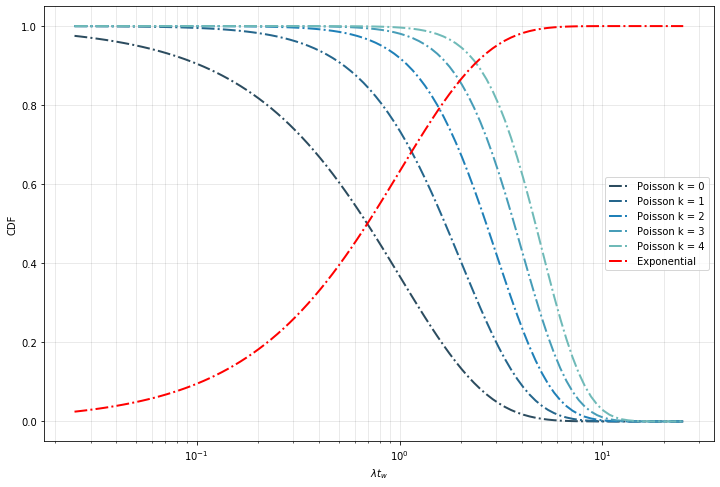

In [3]:
# optional cell to plot the CDF

import matplotlib.pyplot as pplt
import seaborn

inchX = 12
inchY = 8
linewidth_model = 2

fig1 = pplt.figure()
fig1.set_size_inches(inchX, inchY, forward=True)
ax1 = fig1.gca()

ax1.set_xlabel(r'$\lambda t_w$')
ax1.set_ylabel(r'CDF')

K = 5
ygbd = seaborn.color_palette('YlGnBu_d', n_colors=K)
#yord = seaborn.color_palette('YlOrRd_d', n_colors=K)

for i in range(K):
    labl = r'Poisson k = {0}'.format(i)

    ax1.semilogx(lambda_tw, PoissCDF(i), linewidth=linewidth_model, linestyle='-.', color=ygbd[i], label=labl )
ax1.semilogx(lambda_tw, cumulative, linewidth=linewidth_model, linestyle='-.', color='red', label='Exponential' )
    
lg1 = ax1.legend(loc=0, frameon=True)

ax1.patch.set_facecolor('w')
ax1.grid(True, color='black', alpha=.1, which='both', linestyle='-')

## Entropy
The *randomness* or *uncertainty* of the output is measured as **entropy**. The most common measures are [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) in general

$H _{1}(X)\equiv \lim _{\alpha \to 1}H_{\alpha }(X)=-\sum _{i=1}^{n}p_{i}\log p_{i}$,

and [min-entropy](https://en.wikipedia.org/wiki/Min-entropy) for RNG in particular as the worst-case uncertainty produced

$H_{\infty }(X)\doteq \min _{i}(-\log p_{i})=-(\max _{i}\log p_{i})=-\log \max _{i}p_{i}$.

For reference, there is also a function called [Rényi entropy](https://en.wikipedia.org/wiki/R%C3%A9nyi_entropy) that generalizes special cases.

In [20]:
def H_Shannon(pmf):
    return -numpy.sum(pmf*numpy.log2(pmf), axis=0)

def H_min(pmf):
    #return -numpy.log2(numpy.nanmax(pmf, axis=0))
    return numpy.nanmin(-numpy.log2(pmf), axis=0)

## SPAD-based QRNG comparison

### Burri
Perhaps the simplest design is due to [Burri et al.](https://infoscience.epfl.ch/record/191217?ln=en), who propose a single-SPAD randel outputting one bit with a decision rule of whether a photon detection has occurred in $t_w$ or not:

$\begin{align}
    \delta(\tau) & = \begin{cases}1\quad \tau \leq t_w \\ 0 \quad \mbox{o/w}\end{cases} \\
    \mathbb{P}(\delta(\tau)=1) & = \mathcal{E}(t_w, \lambda)
\end{align}$

### Oversampling
The oversampling technique is based on the observation that the lower the frequency of events per unit time, the more uniformly the few recorded events are distributed.

In [28]:
def Burri():
    
    p_zeros = survival
    p_ones = cumulative

    bitrate = numWindows*numpy.ones(numDots)
    entropy_per_bit = H_Shannon(numpy.stack((p_zeros, p_ones)))
    min_per_bit = H_min(numpy.stack((p_zeros, p_ones)))
    entropy_per_second = bitrate * entropy_per_bit
    min_per_second = bitrate * min_per_bit
    return (entropy_per_second, min_per_second)

def oversampling(TDC_bits):
    numBins = [2**TDC_bits]
    entropy_oversampling = numpy.array([])
    min_oversampling = numpy.array([])
    
    for b in range(len(numBins)):

        t_b = float(tw) / numBins[b]

        for f in range(len(lambda_0)):
            l = lambda_0[f]
            equidistantBins = numpy.arange(0, t_b*numBins[b], t_b)
            n = numpy.arange(1,numBins[b]+1,1)
            pmf = (1-numpy.exp(-n*l*t_b)) - (1-numpy.exp(-(n-1)*l*t_b))
            pmf_norm = pmf/numpy.sum(pmf)
            entropy_oversampling = numpy.append(entropy_oversampling, H_Shannon(pmf))
            min_oversampling = numpy.append(min_oversampling, H_min(pmf))

    entropy_per_second = entropy_oversampling*cumulative*numWindows
    min_per_second = min_oversampling*cumulative*numWindows
    return (entropy_per_second, min_per_second)

def Bisadi(TDC_bits):

    entropy_per_second = TDC_bits*PoissPMF(1)*numWindows
    return entropy_per_second
    
def spatial_difference(mismatch, offset, crosstalk):
    
    m=mismatch
    lambda_1 = m*lambda_0
    lambda_plus = lambda_0+lambda_1
    tp = offset
    Sp0 = numpy.exp(-lambda_0*tp)
    Sp1 = numpy.exp(-lambda_1*tp)
    pc = crosstalk

    p = lambda_0*Sp1*(1-pc)/lambda_plus
    #p1 = lambda_1*Sp0*(1-pc)/lambda_plus
    q = 1-p		
    H = H_Shannon([p,q])#-p*numpy.log2(p) -q*numpy.log2(q)
    Hmin = H_min([p,q])
    prob_empty = survival**2
    entropy_per_second = (1-prob_empty)*H*numWindows
    min_per_second = (1-prob_empty)*Hmin*numWindows
    
    return (entropy_per_second, min_per_second)
    
def Hps(labl, H):
    
    if H == 'Shannon':
        switch = 0
    elif H == 'min':
        switch = 1
        
    if labl == 'Burri':

        return Burri()[switch]

    elif labl == 'oversampling, 8 bits':
        
        return oversampling(8)[switch]
        
    elif labl == 'oversampling, 1 bit':
        
        return oversampling(1)[switch]
        
    elif labl == 'spatial difference':

        return spatial_difference(1.1, 1e-10, .05)[switch]
    
    elif labl == 'Bisadi, 8 bits':

        return Bisadi(8)
    
    elif labl == 'Bisadi, 1 bit':

        return Bisadi(1)

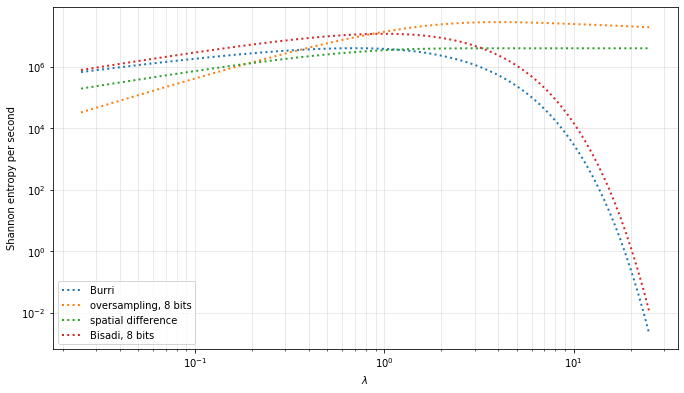

In [36]:
import matplotlib.pyplot as pplt
import seaborn

# list of items to be plotted
item = [
        'Burri', 
        'oversampling, 8 bits', 
        #'oversampling, 1 bit', 
        'spatial difference',
        'Bisadi, 8 bits',
        #'Bisadi, 1 bit'
       ]

numItems = len(item)
helix = seaborn.cubehelix_palette(numItems, start=1.8, rot=-1.25)
pairs = seaborn.color_palette("tab20")

scale = .7
inchX = 16*scale
inchY = 9*scale
linewidth_model = 2

# Shannon entropy

fig2 = pplt.figure()
fig2.set_size_inches(inchX, inchY, forward=True)
ax2 = fig2.gca()

ax2.set_xlabel(r'$\lambda$')
ax2.set_ylabel(r'Shannon entropy per second')

for i in range(numItems):
    labl = item[i]
    ax2.loglog(lambda_tw, Hps(labl,'Shannon'), linewidth=linewidth_model, linestyle=':', color=pairs[2*i], label=labl )

lg2 = ax2.legend(loc=0, frameon=True)

ax2.patch.set_facecolor('w')
ax2.grid(True, color='black', alpha=.1, which='both', linestyle='-')


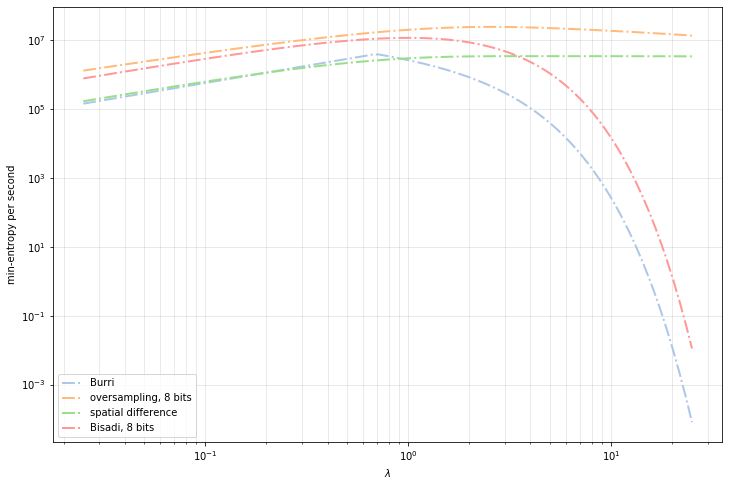

In [29]:
# min-entropy

fig3 = pplt.figure()
fig3.set_size_inches(inchX, inchY, forward=True)
ax3 = fig3.gca()

ax3.set_xlabel(r'$\lambda$')
ax3.set_ylabel(r'min-entropy per second')

for i in range(numItems):
    labl = item[i]
    ax3.loglog(lambda_tw, Hps(labl, 'min'), linewidth=linewidth_model, linestyle='-.', color=pairs[2*i+1], label=labl )

lg3 = ax3.legend(loc=0, frameon=True)

ax3.patch.set_facecolor('w')
ax3.grid(True, color='black', alpha=.1, which='both', linestyle='-')


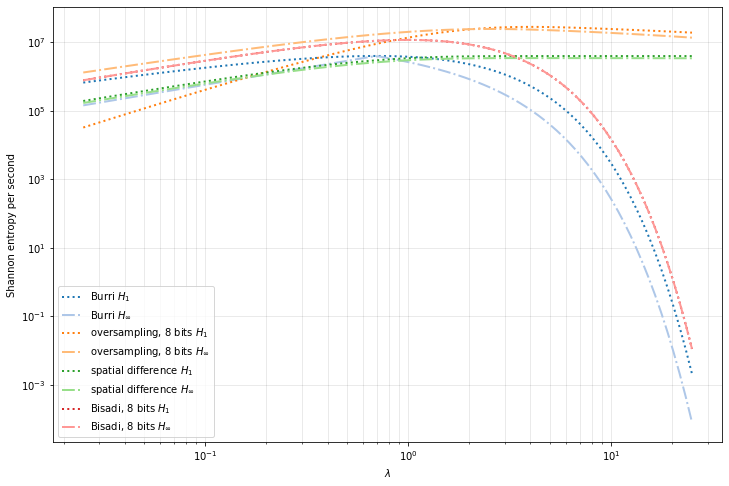

In [31]:
# combined entropy graph

fig4 = pplt.figure()
fig4.set_size_inches(inchX, inchY, forward=True)
ax4 = fig4.gca()

ax4.set_xlabel(r'$\lambda$')
ax4.set_ylabel(r'Shannon entropy per second')

for i in range(numItems):
    labl = item[i]
    ax4.loglog(lambda_tw, Hps(labl,'Shannon'), linewidth=linewidth_model, linestyle=':', color=pairs[2*i], label=labl+' $H_{1}$' )
    ax4.loglog(lambda_tw, Hps(labl, 'min'), linewidth=linewidth_model, linestyle='-.', color=pairs[2*i+1], label=labl+' $H_{\infty}$' )

lg4 = ax4.legend(loc=0, frameon=True)

ax4.patch.set_facecolor('w')
ax4.grid(True, color='black', alpha=.1, which='both', linestyle='-')


## Notation
$\lambda$ - photon detections per second

$t_w$ - window of time (seconds)

$\mathcal{E}(t_w, \lambda)$ - cumulative distribution function, exponential

$\mathcal{P}(t_w, \lambda, k)$ - cumulative distribution function, Poisson


# Theme
You can run the following cell to change the appearance of this notebook to suit your taste. Check for available themes on [github.com/dunovank/jupyter-themes](https://github.com/dunovank/jupyter-themes).

In [7]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('chesterish')